The purpose is the test the sensitivity of inference to priors to mispecification, and identifiability of model parameters as priors become uninformative. First under errorless data, then with some noise added.

In [1]:
import argparse
import os

from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey
from jax import nn
from jax.lib import xla_bridge

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd
import numpy as np

import arviz as az
import bokeh
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from arviz.utils import conditional_jit, Numba
Numba.disable_numba()
Numba.numba_flag

False

In [3]:
NUM_CORES = 1
numpyro.set_host_device_count(NUM_CORES)
numpyro.set_platform('cpu')
print(xla_bridge.get_backend().platform)

cpu


The simulated data was generated by a set of 3 coupled competitive LV equations specified by the parameters:

Population fraction initialisations:
$z_0, z_1, z_2 = 0.75, 0.10, 0.15$

Inherent growth rates:
$r_1, r_2 = 1, 1.5$

Self-interactions:
$a_{11}, a_{22} = 1.5, 1$

Competitive interactions:
$a_{12},a_{13},a_{21},a_{23} = 2.5, 1.5, 1, 0.6$

The population of the third category is calculated via the sum condition:
$z_3 = 1 - z_1 - z_2$




### Mildly informative priors

Dirchlet initialisation

+

N(x,1) about the simulated values

In [29]:
def dz_dt(z, 
          t, 
          inherent_growth_rate, 
          self_interaction,
          comp_interaction
         ):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    
    r1, r2 = (inherent_growth_rate[..., 0], 
              inherent_growth_rate[..., 1], 
             )
    
    a11, a22 = (self_interaction[..., 0], 
                self_interaction[..., 1], 
               )
    
    a12, a13, a21, a23 = (comp_interaction[..., 0], 
                                    comp_interaction[..., 1],
                                    comp_interaction[..., 2], 
                                    comp_interaction[..., 3], 
                                   )

    
    dz1_dt = r1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3))
    dz2_dt = r2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3))
    dz3_dt = - dz1_dt - dz2_dt
    
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt])


def model(N : int, y = None, sigma = None):

    ts = jnp.arange(float(N))
    z_init = numpyro.sample("z_init", dist.Dirichlet(jnp.array([1,1,1])))
    

    inherent_growth_rate = numpyro.sample("inherent_growth_rate", 
                               dist.TruncatedNormal(
                                   low = 0.,
                                   loc = jnp.array([0.125, 0.25]),
                                   scale = jnp.repeat(sigma, 2),
                                   )
                              )
        

    self_interaction = numpyro.sample("self_interaction", 
                               dist.TruncatedNormal(
                                   low = 0.,
                                   loc = jnp.array([1.5, 1.]),
                                   scale = jnp.repeat(sigma, 2),
                                   )
                              )
        

    comp_interaction = numpyro.sample("comp_interaction", 
                               dist.TruncatedNormal(
                                   low = 0.,
                                   loc = jnp.array([2.5, 1.5, 1., 0.6]),
                                   scale = jnp.repeat(sigma, 4),
                                   )
                              )
    
    z = odeint(dz_dt, z_init, ts, inherent_growth_rate, self_interaction,
          comp_interaction, rtol = 1e-8, atol = 1e-7, mxstep = 1500)
    
    numpyro.sample("y", dist.Multinomial(probs = z, total_count = 100), obs = y)
    
def run_mcmc(model, sigma, y, iter_):    
    mcmc = MCMC(
        NUTS(model, dense_mass = True),
        num_samples = iter_,
        num_warmup = iter_,
        num_chains = NUM_CORES,
        progress_bar = True,
    )

    mcmc.run(PRNGKey(1), N = y.shape[0], y = y, sigma = sigma)
    mcmc.print_summary()
    
    return mcmc


def plt_posterior_pred(model, mcmc, sigma, y):
    pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), y.shape[0], sigma = sigma)["y"]
    mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

    plt.figure(figsize=(8, 6), constrained_layout=True)
    plt.plot(week, y[:, 0], "ko", mfc="none", ms=4, label="VOC1", alpha=0.67)
    plt.plot(week, y[:, 1], "bx", label="VOC2")
    plt.plot(week, y[:, 2], "r+", label="VOC3")
    # plt.plot(week, trans_data[:, 3], "g+", label="VOC4")
    plt.plot(week, mu[:, 0], "k-.", label="VOC1", lw=1, alpha=0.67)
    plt.plot(week, mu[:, 1], "b--", label="VOC2")
    plt.plot(week, mu[:, 2], "r--", label="VOC3")
    # plt.plot(week, mu[:, 3], "g--", label="VOC4")
    plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
    plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
    plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
    # plt.fill_between(week, pi[0, :, 3], pi[1, :, 3], color="g", alpha=0.1)
    plt.gca().set(ylim=(0, 105), xlabel="week", ylabel="population (%)")
    plt.title("Posterior predictive (80% CI) for Comp. Lotka-Volterra eqns.")
    plt.legend(loc=(1.04,0))
    plt.show()

    
def plt_posterior_param(mcmc):
    mcmc_from_numpyro = az.from_numpyro(mcmc)
    az.plot_trace(mcmc_from_numpyro, compact = True, combined = True);
    plt.show()

    az.plot_forest(mcmc_from_numpyro, var_names = ['comp_interaction'], combined = True)
    plt.show()

    az.plot_forest(mcmc_from_numpyro, var_names = ['inherent_growth_rate'], combined = True)
    plt.show()

    az.plot_forest(mcmc_from_numpyro, var_names = ['self_interaction'], combined = True)
    plt.show()

    az.plot_forest(mcmc_from_numpyro, var_names = ['z_init'], combined = True)
    plt.show()

    az.plot_pair(mcmc_from_numpyro, var_names = ['comp_interaction', 'inherent_growth_rate'])
    plt.show()

In [31]:
df = pd.read_csv("../data/sim3.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2],df.iloc[:,3]]).T

trans_data =  np.round(100 * data)
trans_data[:,2] = 100 - (trans_data[:,0] + trans_data[:,1])
trans_data[:5]
trans_data_p = trans_data

sample: 100%|██████████| 1000/1000 [00:22<00:00, 44.98it/s, 63 steps of size 6.79e-02. acc. prob=0.81]  



                             mean       std    median      5.0%     95.0%     n_eff     r_hat
    comp_interaction[0]      3.30      0.85      3.33      1.75      4.50    150.02      1.01
    comp_interaction[1]      1.85      0.61      1.80      0.85      2.82    137.18      1.00
    comp_interaction[2]      0.76      0.47      0.75      0.02      1.39     52.11      1.00
    comp_interaction[3]      0.20      0.14      0.20      0.00      0.41     58.82      1.00
inherent_growth_rate[0]      1.03      0.43      0.94      0.45      1.68    197.28      1.01
inherent_growth_rate[1]      0.81      0.14      0.78      0.60      1.05     63.35      1.00
    self_interaction[0]      1.46      0.37      1.42      0.88      2.02    260.50      1.01
    self_interaction[1]      1.04      0.01      1.04      1.03      1.06     86.41      1.00
              z_init[0]      0.72      0.04      0.71      0.65      0.78    194.90      1.01
              z_init[1]      0.06      0.02      0.06      

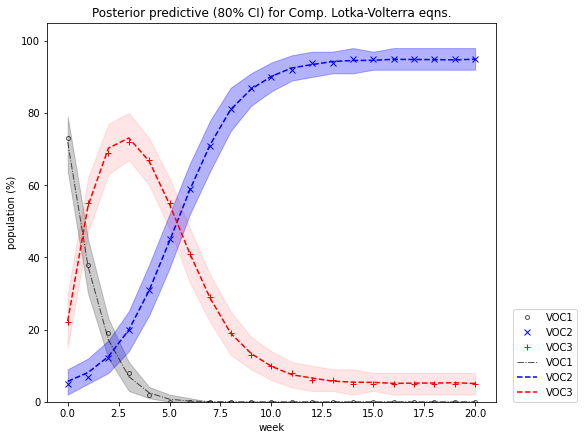

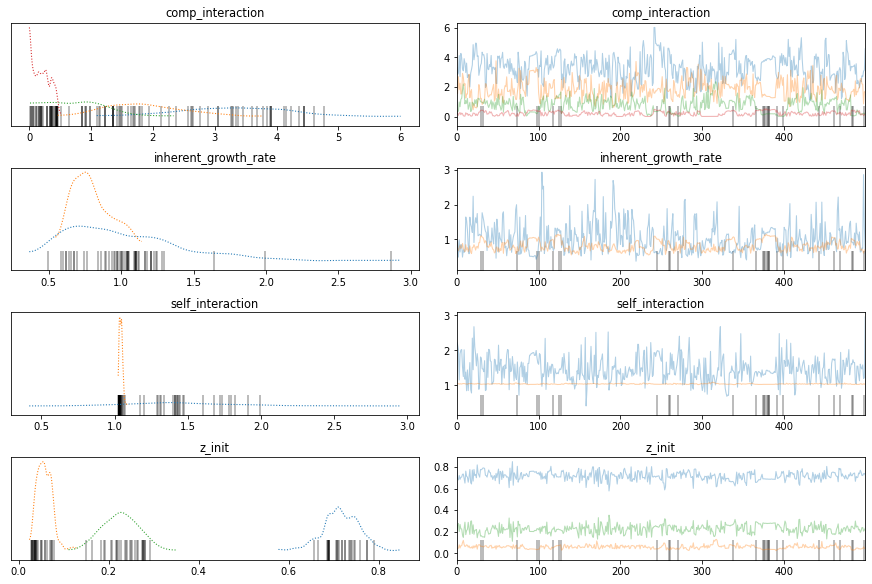

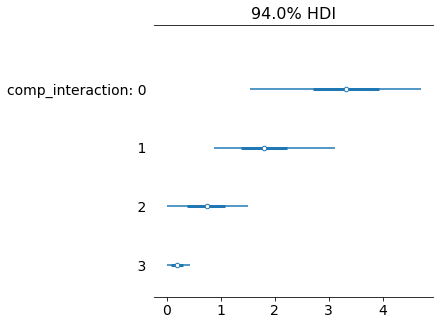

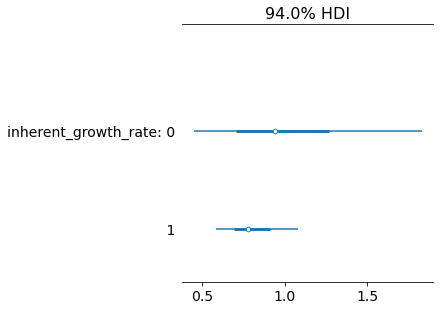

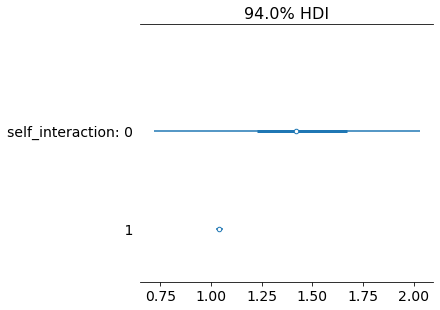

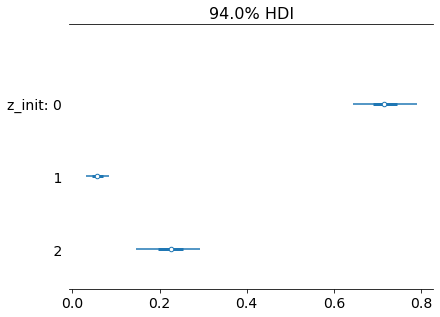

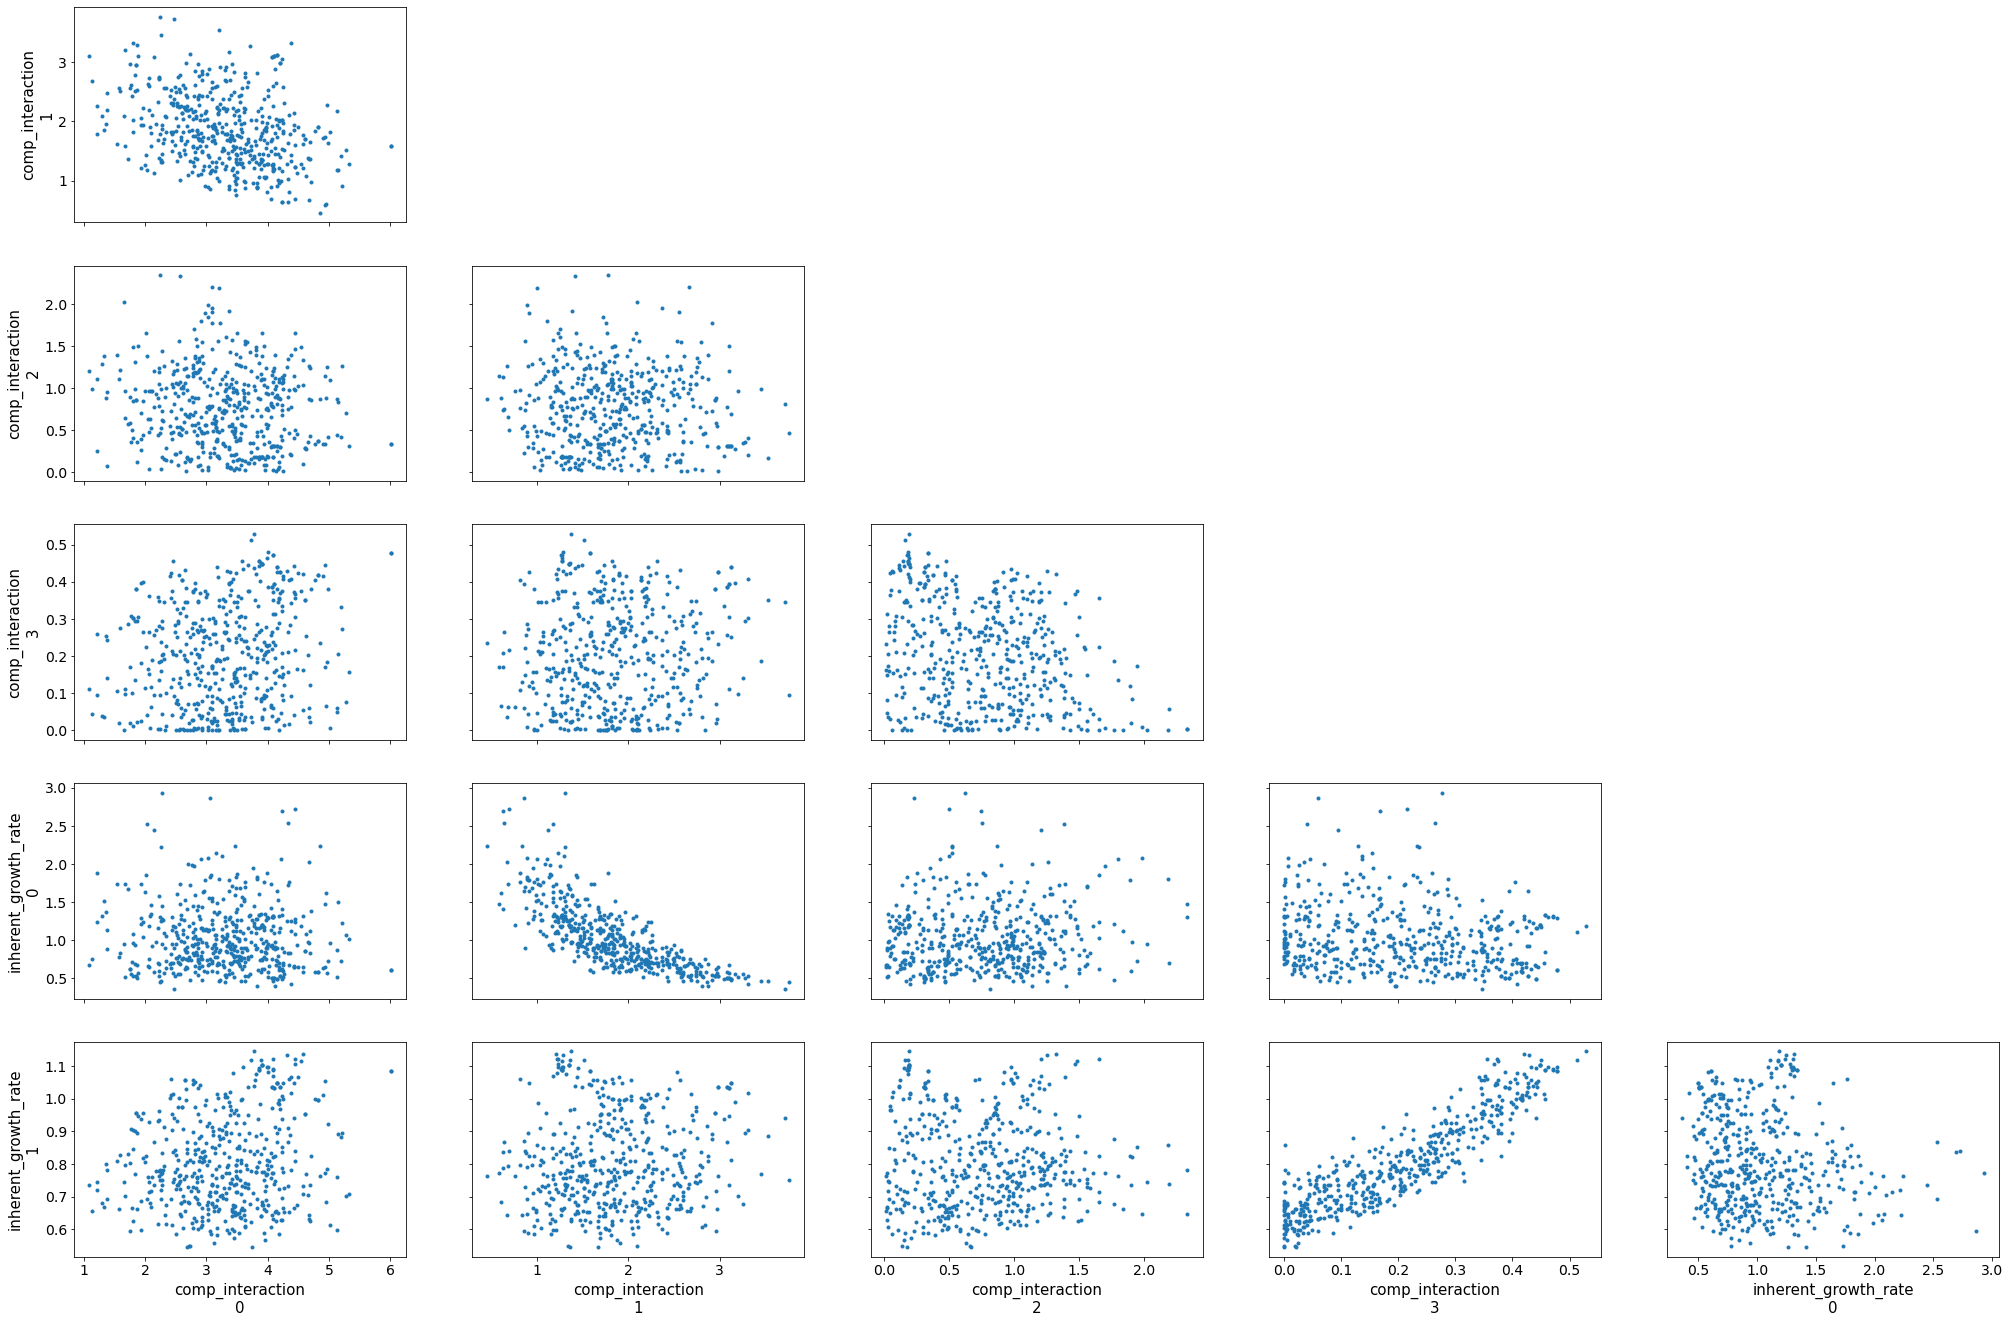

In [32]:
mcmc = run_mcmc(model = model, sigma = 1., y = trans_data_p, iter_ = 500)
plt_posterior_pred(model = model, mcmc = mcmc, sigma = 1., y = trans_data_p)
plt_posterior_param(mcmc = mcmc)

In [35]:
# this data is a noisier and a bit longer
df = pd.read_csv("../data/sim3morepoints.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2],df.iloc[:,3]]).T

trans_data =  np.round(100 * data)
trans_data[:,2] = 100 - (trans_data[:,0] + trans_data[:,1])
assert np.repeat(100., trans_data.shape[0]).all() == trans_data.sum(axis = 1).all()
trans_data_p = trans_data.copy()
trans_data[:5]


array([[66.,  0., 34.],
       [46.,  0., 54.],
       [33.,  0., 67.],
       [17.,  1., 82.],
       [16.,  7., 77.]])

sample: 100%|██████████| 1000/1000 [00:57<00:00, 17.31it/s, 183 steps of size 2.27e-02. acc. prob=0.75]



                             mean       std    median      5.0%     95.0%     n_eff     r_hat
    comp_interaction[0]      3.20      0.97      3.30      1.41      4.52    120.47      1.04
    comp_interaction[1]      1.83      0.59      1.68      1.02      2.70     61.32      1.02
    comp_interaction[2]      0.23      0.23      0.16      0.00      0.58     26.88      1.05
    comp_interaction[3]      0.65      0.15      0.70      0.42      0.81     35.57      1.03
inherent_growth_rate[0]      1.01      0.51      0.93      0.23      1.69     87.56      1.00
inherent_growth_rate[1]      1.18      0.38      1.19      0.63      1.79     28.29      1.03
    self_interaction[0]      1.03      0.29      1.00      0.53      1.44     91.28      1.02
    self_interaction[1]      1.04      0.02      1.03      1.02      1.06     37.89      1.03
              z_init[0]      0.64      0.04      0.64      0.57      0.71    102.15      1.00
              z_init[1]      0.01      0.00      0.01      

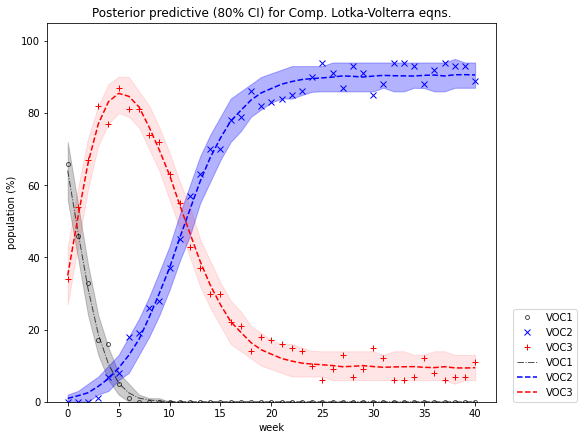

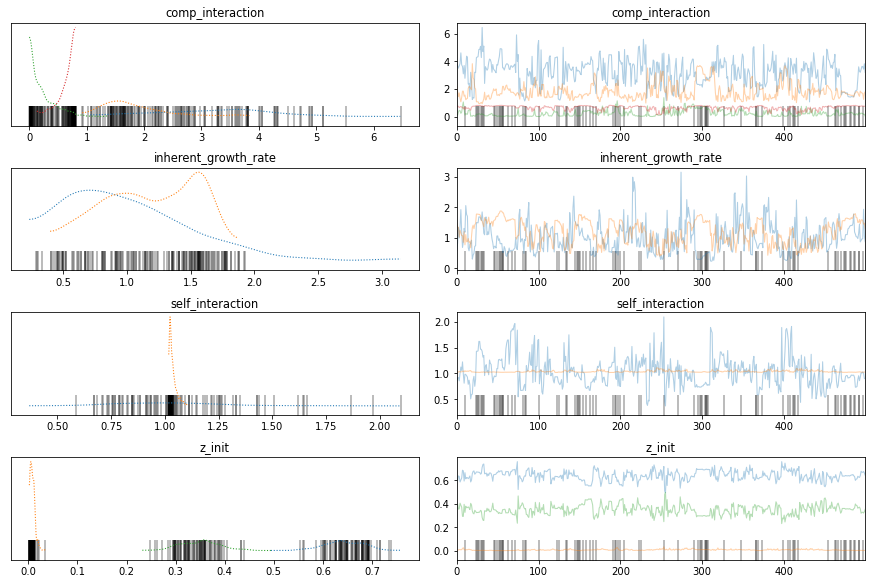

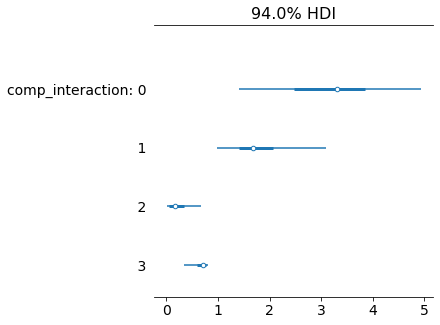

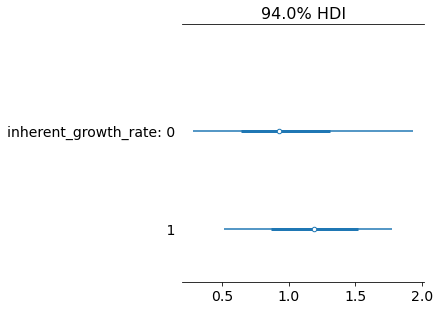

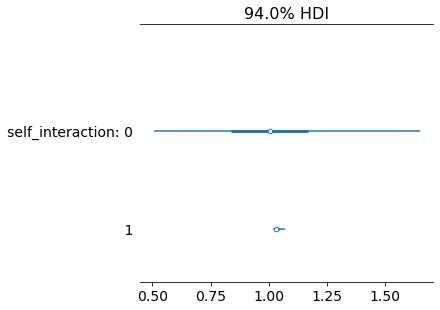

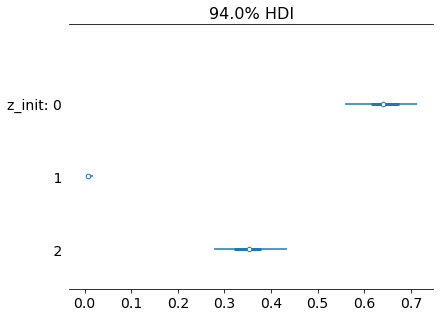

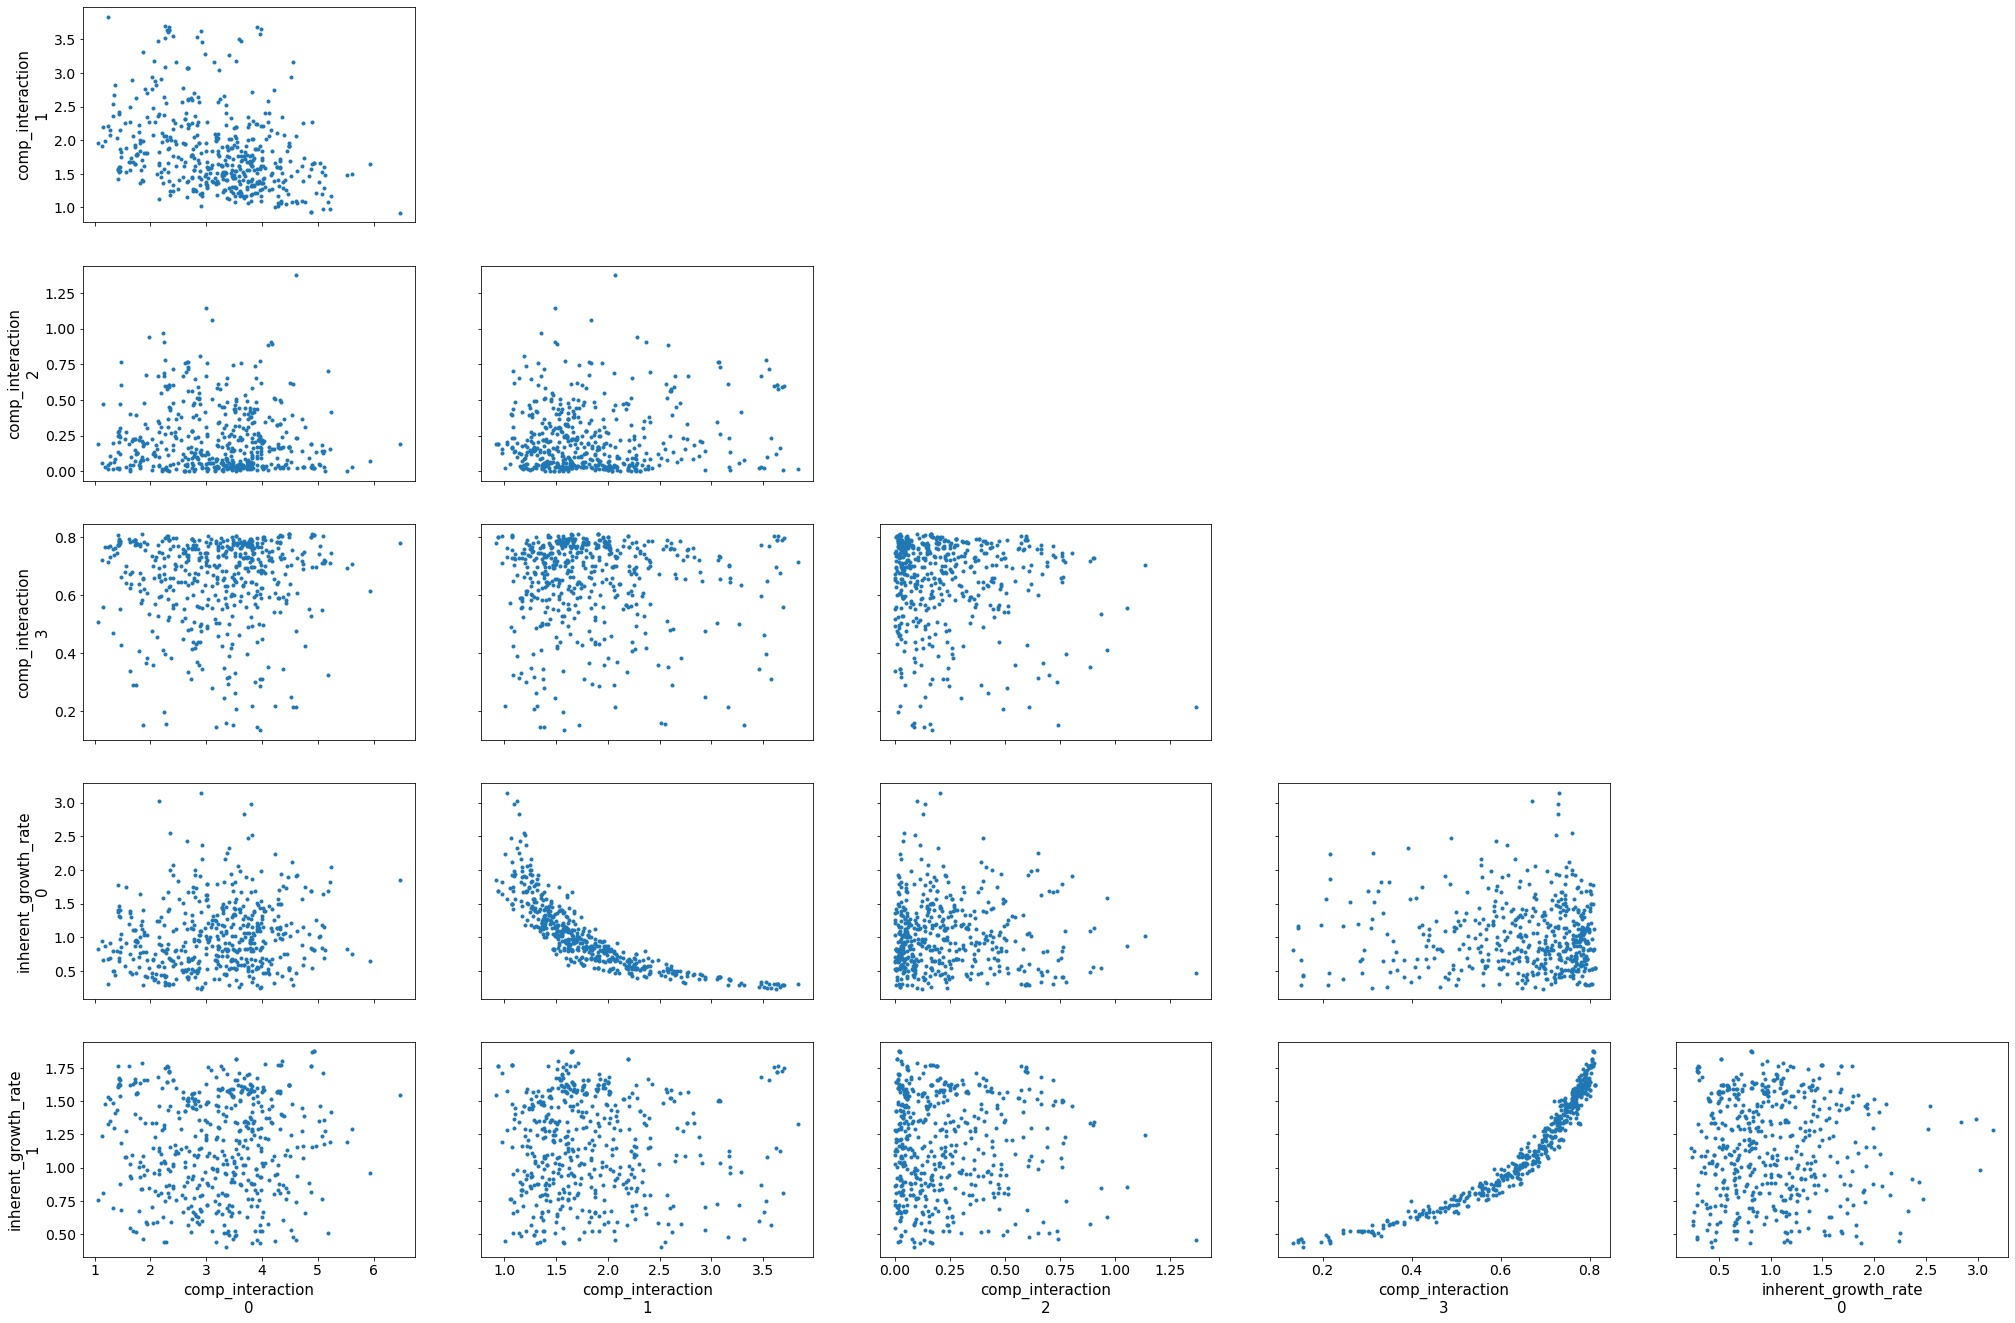

In [36]:
mcmc = run_mcmc(model = model, sigma = 1., y = trans_data_p, iter_ = 500)
plt_posterior_pred(model = model, mcmc = mcmc, sigma = 1., y = trans_data_p)
plt_posterior_param(mcmc = mcmc)

posterior is a bit badly shaped. I wonder if it helps at all to share some info between parameters

In [58]:
def model_hierarchical2(N : int, 
                        y = None, 
                        sigma = None):

    ts = jnp.arange(float(N))
    z_init = numpyro.sample("z_init", dist.Dirichlet(jnp.array([1,1,1])))
    
    loc_inherent_growth_rate = numpyro.sample("loc_inherent_growth_rate", 
                                              dist.TruncatedNormal(0.5, sigma))
    scale_inherent_growth_rate = numpyro.sample("scale_inherent_growth_rate", 
                                                dist.TruncatedNormal(sigma, sigma))
    with numpyro.plate("plate_1", 1):
        inherent_growth_rate = numpyro.sample("inherent_growth_rate", 
                                   dist.TruncatedNormal(
                                       low = 0.,
                                       loc = loc_inherent_growth_rate,
                                       scale = scale_inherent_growth_rate,
                                       )
                                  )
        
    loc_self_interaction = numpyro.sample("loc_self_interaction", 
                                              dist.TruncatedNormal(1, sigma))
    scale_self_interaction = numpyro.sample("scale_self_interaction", 
                                            dist.TruncatedNormal(sigma, sigma))
    with numpyro.plate("plate_2", 2):
        self_interaction = numpyro.sample("self_interaction", 
                                   dist.TruncatedNormal(
                                       low = 0.,
                                       loc = loc_self_interaction,
                                       scale = scale_self_interaction,
                                       )
                                  )
    loc_comp_interaction = numpyro.sample("loc_comp_interaction", 
                                            dist.TruncatedNormal(1, sigma))
    scale_comp_interaction = numpyro.sample("scale_comp_interaction", 
                                            dist.TruncatedNormal(sigma, sigma))
    with numpyro.plate("plate_3", 3):
        comp_interaction = numpyro.sample("comp_interaction", 
                                   dist.TruncatedNormal(
                                       low = 0.,
                                       loc = loc_comp_interaction,
                                       scale = scale_comp_interaction,
                                       )
                                  )
    
    z = odeint(dz_dt, z_init, ts, inherent_growth_rate, self_interaction,
          comp_interaction, rtol = 1e-8, atol = 1e-7, mxstep = 1500)
    
    numpyro.sample("y", dist.Multinomial(probs = z, total_count = 100), obs = y)

sample: 100%|██████████| 1000/1000 [05:47<00:00,  2.88it/s, 1023 steps of size 4.82e-04. acc. prob=0.88]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
         comp_interaction[0]      6.43      0.56      6.47      5.65      7.46     13.42      1.10
         comp_interaction[1]      0.06      0.00      0.06      0.06      0.06      8.26      1.35
         comp_interaction[2]      0.65      0.02      0.65      0.62      0.68     14.70      1.08
     inherent_growth_rate[0]      1.23      0.06      1.23      1.14      1.33     20.26      1.00
        loc_comp_interaction      1.41      0.01      1.41      1.39      1.42      5.00      1.09
    loc_inherent_growth_rate      5.42      0.33      5.47      4.96      5.86      6.80      1.30
        loc_self_interaction      4.83      0.12      4.83      4.62      5.03     13.02      1.03
      scale_comp_interaction      2.13      0.11      2.13      1.97      2.29      4.33      1.62
  scale_inherent_growth_rate      1.52      0.06      1.53      1.41      1.61      3.93      1.77
      sca

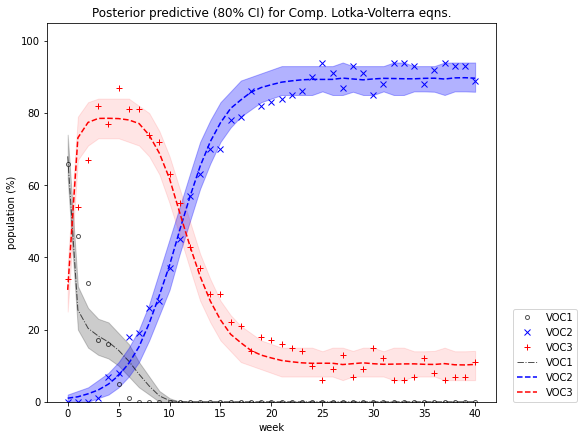

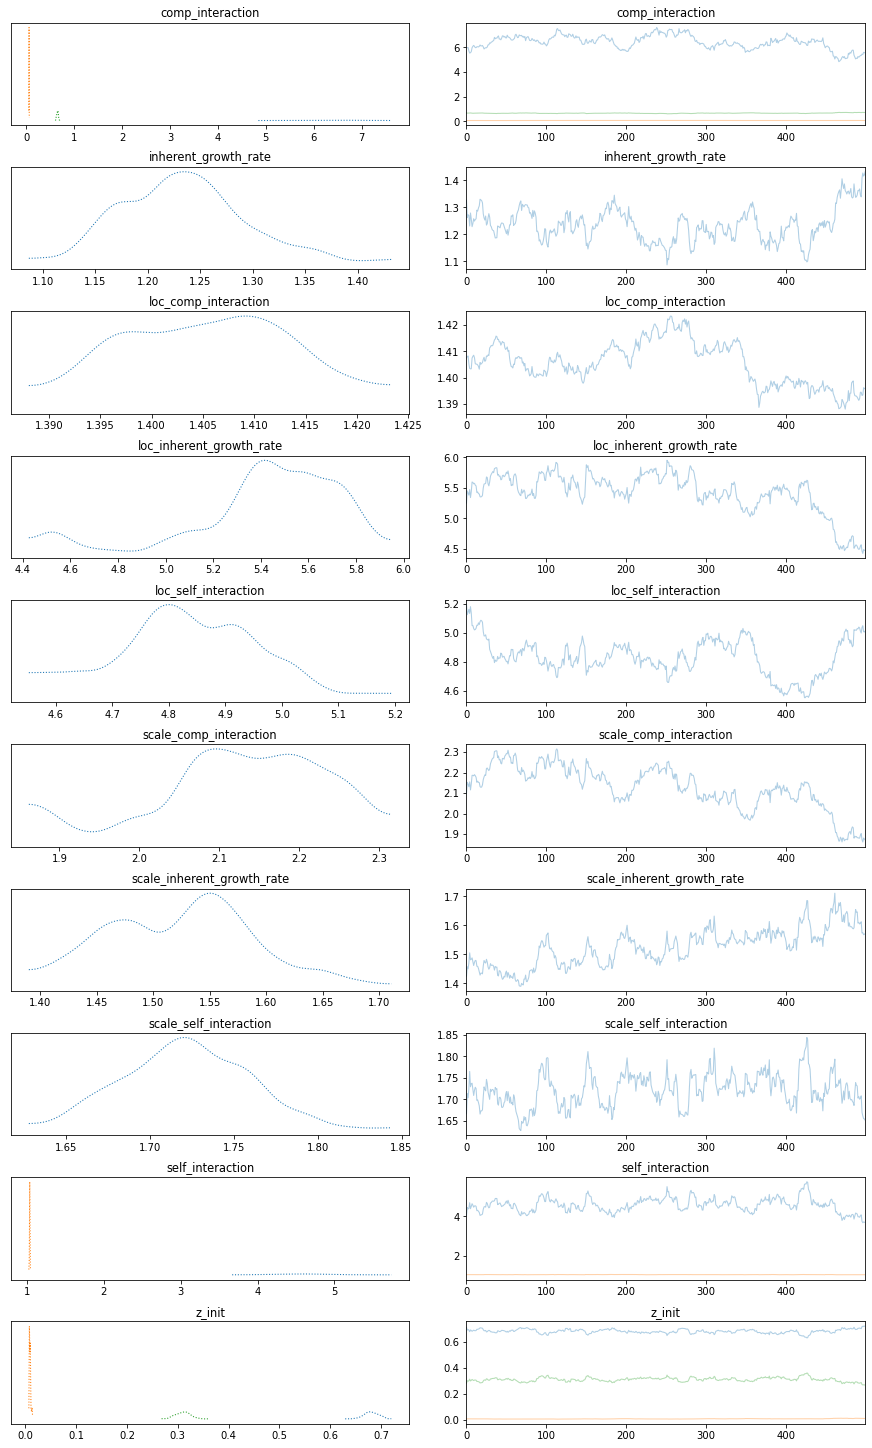

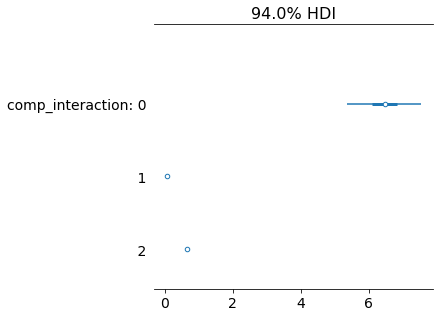

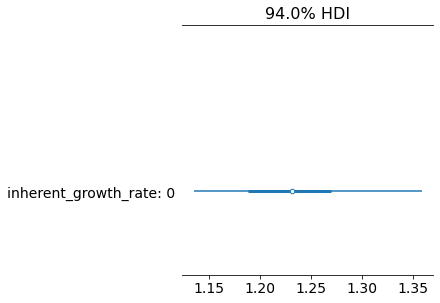

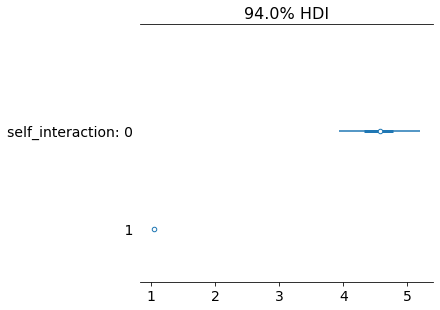

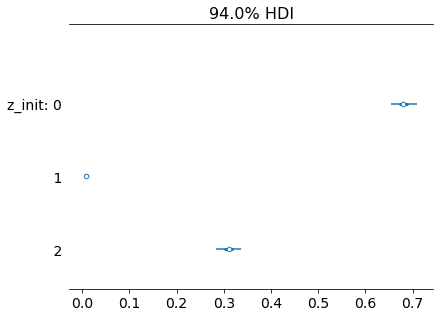

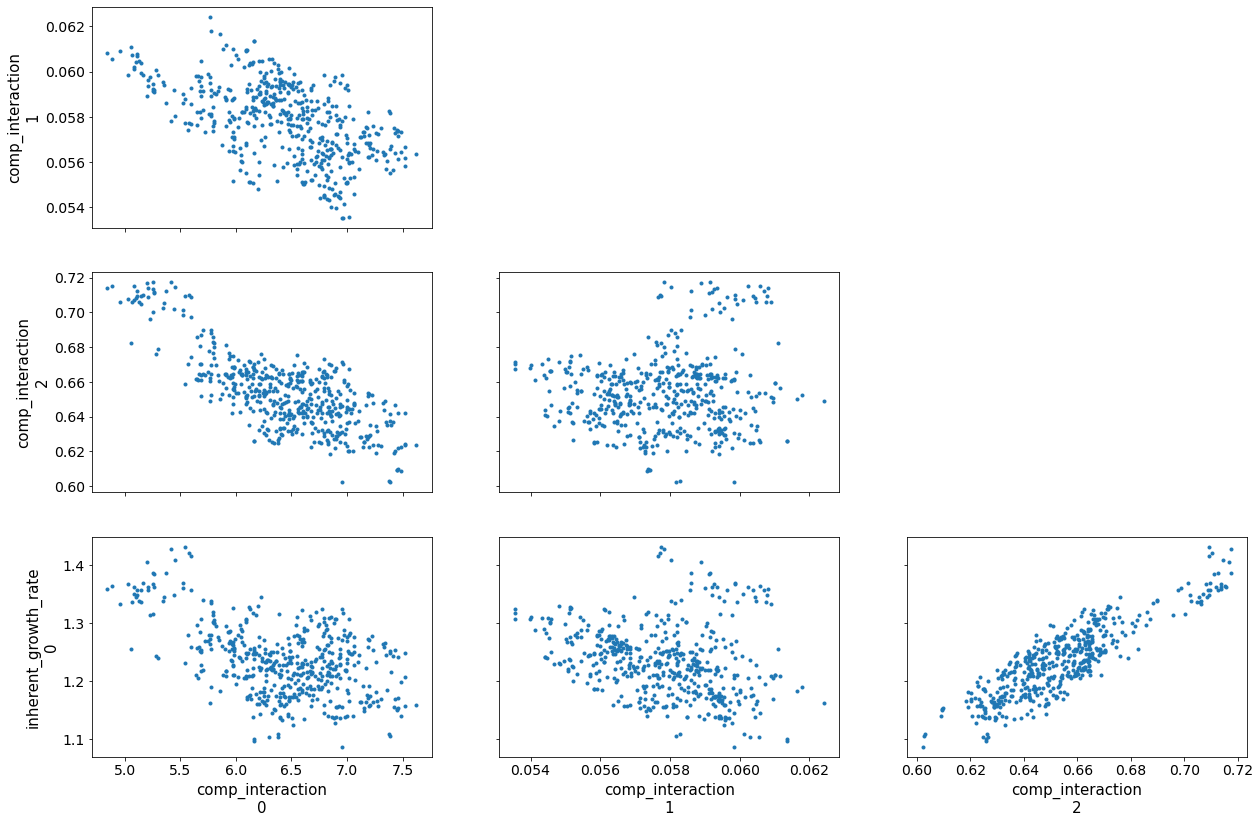

In [59]:
mcmc = run_mcmc(model = model_hierarchical2, sigma = 1., y = trans_data_p, iter_ = 500)
plt_posterior_pred(model = model_hierarchical2, mcmc = mcmc, sigma = 1., y = trans_data_p)
plt_posterior_param(mcmc = mcmc)